# Prise en main des concepts du Deep Learning

<br/>

##### Arnaud Deleruyelle : Doctorant SIGMA - BioComputing
##### Encadrement: John Klein (SIGMA) - Cristian Versari (BioComputing)

## Partie 1 : Initialisation du code

Nous allons traiter ce travail à l'aide de la bibliothèque Tensorflow de Google. 
Cette partie va se consacrer à la gestion des imports, la création des données etc...

### Section 1.1: Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sin
from IPython.core.display import Image, display

### Section 1.2: Création d'un dataset artificiel

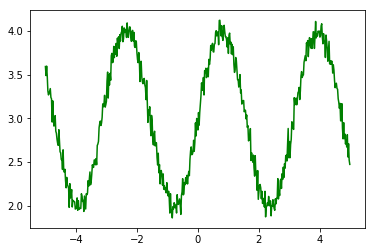

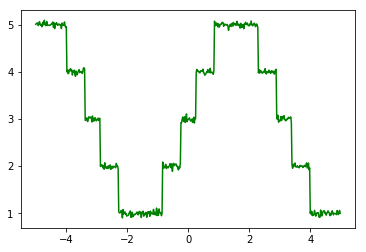

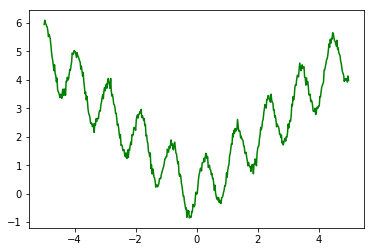

In [2]:
# dataset

def f_sin(x): return sin(2*x) + 3

def f_round(x): return round(2*sin(x) + 3)

def f_absin(x): return sin(6*x) + abs(x)


x = np.arange(-5, 5, 0.02).reshape(-1,1)
y_f1 = np.array([f_sin(x) + np.random.normal(0, 0.08) for x in x]).reshape(-1,1)
y_f2 = np.array([f_round(x) + np.random.normal(0, 0.04) for x in x]).reshape(-1,1)
y_f3 = np.array([f_absin(x) + np.random.normal(0, 0.1) for x in x]).reshape(-1,1)


plt.plot(x,y_f1, 'green')
plt.show()

plt.plot(x,y_f2, 'green')
plt.show()

plt.plot(x,y_f3, 'green')
plt.show()


### Section 1.3: Variables Globales

In [3]:
epochs = 20000
batch_size = 100

x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='x_batch')
y_batch = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_batch')

### Section 1.4: Fit

In [4]:
def Fit(x_train,y_train,model, verbose = 2000):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            print("Loss = ", sess.run(avg_llh, feed_dict=feed_dict))
    return sess

### Section 1.5: Predict

In [5]:
def Predict(x_test,session):
    feed_dict = {x_batch: x_test}
    yh_vals = session.run((y_pred), feed_dict=feed_dict)
    return yh_vals

    

### Section 1.6: MLP

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal([int(shape[0]),shape[1]], stddev=0.1)
    return tf.Variable(initial, dtype = tf.float32)
 
# The constant value 0.1
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, dtype = tf.float32)


def MLP(x_b,tab_neurones, tab_activation, dropout = 1, name="MLP"):
    with tf.name_scope(name):
        outs = []
        for i in range(len(tab_neurones)):
            if i == 0 :
                input_nb_neurone = x_b.shape[1]
                input_data = x_b
            else:
                input_nb_neurone = tab_neurones[i-1]
                input_data = outs[i-1]
            W = weight_variable([input_nb_neurone, tab_neurones[i]])
            b = bias_variable([tab_neurones[i]])
            if (tab_activation[i] == "relu"):
                out = tf.nn.relu(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "sigmoid"):
                out = tf.nn.sigmoid(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "tanh"):
                out = tf.tanh(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "softmax"):
                out = tf.nn.softmax(tf.matmul(input_data, W) + b)
            else:
                out = tf.matmul(input_data, W) + b
            # gestion du dropout
            if (dropout != 1) & (i != len(tab_neurones)-1):
                out_drop = tf.nn.dropout(out, dropout)
                outs.append(out_drop)
            else:
                outs.append(out)
        return outs

### Section 1.7: Test d'un modèle

In [7]:
mlp1 = MLP(x_batch,[8,8,1], ['tanh','tanh','identity'])

# output layer
y_pred = mlp1[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [8]:
# fit the model
modelFit = Fit(x,y_f1,model)

Loss =  9.144546
Loss =  0.26388893
Loss =  0.0060208454
Loss =  0.008336693
Loss =  0.006467921
Loss =  0.005883794
Loss =  0.005521577
Loss =  0.007315967
Loss =  0.00649956
Loss =  0.005945088


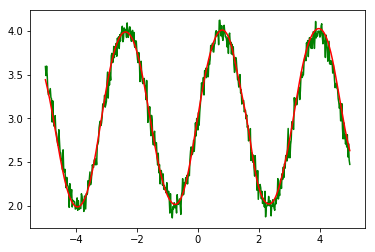

In [9]:
# predict 
modelPredict = Predict(x,modelFit)

plt.plot(x,y_f1, 'green')
plt.plot(x,modelPredict, 'red')
plt.show()

In [10]:
writer = tf.summary.FileWriter("/tmp/graph/1")
writer.add_graph(modelFit.graph)

In [11]:
Image(filename = "/home/adeleruyelle/Images/tsb1.png", width=500, height=500)
modelFit.close()

## Partie 2: Utilisation des différentes fonctions d'activation.

Dans cette partie, nous allons étudier les 4 fonctions d'activation (Relu, sigmoide, tanh, identité).
Pour ce faire, nous avons choisi un optimiseur (Adam) de manière à ne changer que la couche d'activation.

### Section 2.1: fonction de test

In [12]:
# mse

def mse(y_pred,y):
    return np.mean(np.square(y_pred - y))

npArray1 = np.array([1,2,4])
npArray2 = np.array([1,3,7])

print("mse = " + str(mse(npArray1,npArray2)))

# mae

def mae(y_pred,y):
    return np.mean(np.abs(y_pred - y))

print("mae = " + str(mae(npArray1,npArray2)))

mse = 3.3333333333333335
mae = 1.3333333333333333


In [13]:
# test with mean of n launch

def testFunctionActivation(n, x_vals, y_vals, model):
    liste_result = []
    for i in range(n):
        session = Fit(x_vals, y_vals, model, verbose = 5000)
        y_result = Predict(x_vals,session)
        liste_result.append(y_result)
        session.close()
    result = np.mean(liste_result, axis = 0)
    return result.reshape(result.shape[0],1)
        

### Section 2.2: Relu

In [14]:
# model with Relu

mlp_relu = MLP(x_batch,[8,8,8,1], ['relu','relu','relu','identity'])

# output layer
y_pred = mlp_relu[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelRelu = opt.minimize(avg_llh)

In [15]:
# train model
resRelu_sin = testFunctionActivation(5,x,y_f1,modelRelu)
resRelu_round = testFunctionActivation(5,x,y_f2,modelRelu)
resRelu_absin = testFunctionActivation(5,x,y_f3,modelRelu)

Loss =  8.451513
Loss =  0.09198519
Loss =  0.014924996
Loss =  0.013453665
Loss =  7.8335285
Loss =  0.016891077
Loss =  0.016183812
Loss =  0.0101957545
Loss =  8.350674
Loss =  0.4521557
Loss =  0.09574225
Loss =  0.01157263
Loss =  8.8970585
Loss =  0.072739504
Loss =  0.013379513
Loss =  0.01145063
Loss =  8.818243
Loss =  0.12814306
Loss =  0.14527044
Loss =  0.016555406
Loss =  10.8161
Loss =  0.080391
Loss =  0.07549538
Loss =  0.096751556
Loss =  10.6468115
Loss =  0.09956607
Loss =  0.09564563
Loss =  0.07388722
Loss =  11.78275
Loss =  0.109089196
Loss =  0.090802476
Loss =  0.08473162
Loss =  11.388459
Loss =  0.07505607
Loss =  0.06544959
Loss =  0.042715203
Loss =  9.493336
Loss =  0.08292297
Loss =  0.05964406
Loss =  0.04951532
Loss =  8.390486
Loss =  0.48767984
Loss =  0.33371666
Loss =  0.3265142
Loss =  9.019268
Loss =  0.47051808
Loss =  0.5185569
Loss =  0.48959145
Loss =  8.01401
Loss =  0.48670253
Loss =  0.4705515
Loss =  0.31780404
Loss =  8.630991
Loss =  0.5

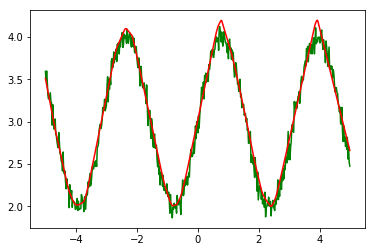

mae = 0.08092513937370256
mse = 0.010285898169585181


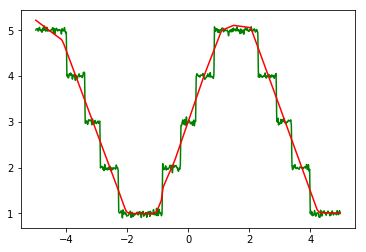

mae = 0.18667384569210677
mse = 0.05888870755252343


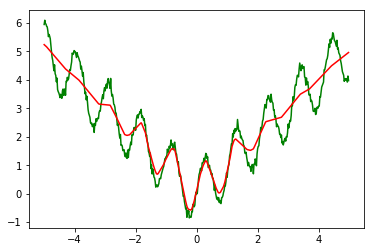

mae = 0.4396009826963192
mse = 0.2899384297922223


In [16]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resRelu_sin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_sin,y_f1)))
print( "mse = " + str(mse(resRelu_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resRelu_round, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_round,y_f2)))
print( "mse = " + str(mse(resRelu_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resRelu_absin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_absin,y_f3)))
print( "mse = " + str(mse(resRelu_absin,y_f3)))

### Section 2.3: Sigmoide

In [17]:
# model with sigmoid

mlp_sigmoid = MLP(x_batch,[8,8,8,1], ['sigmoid','sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_sigmoid[-1]

#loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelSigmoid = opt.minimize(avg_llh)

In [18]:
# train model
resSigmoid_sin = testFunctionActivation(5,x,y_f1,modelSigmoid)
resSigmoid_round = testFunctionActivation(5,x,y_f2,modelSigmoid)
resSigmoid_absin = testFunctionActivation(5,x,y_f3,modelSigmoid)

Loss =  8.349869
Loss =  0.2737888
Loss =  0.28542316
Loss =  0.24047011
Loss =  7.7071157
Loss =  0.32447144
Loss =  0.2524669
Loss =  0.32457492
Loss =  8.38023
Loss =  0.47744164
Loss =  0.28901652
Loss =  0.28565472
Loss =  7.856449
Loss =  0.3446537
Loss =  0.31151316
Loss =  0.29505318
Loss =  7.8109875
Loss =  0.39341536
Loss =  0.25192547
Loss =  0.37533253
Loss =  10.254005
Loss =  1.4187073
Loss =  0.9176971
Loss =  1.075522
Loss =  11.28001
Loss =  1.7797704
Loss =  1.7375375
Loss =  1.9275246
Loss =  10.171696
Loss =  1.840016
Loss =  1.5529563
Loss =  1.6331232
Loss =  10.597634
Loss =  1.9643533
Loss =  1.7495662
Loss =  1.7996581
Loss =  9.470353
Loss =  1.0255694
Loss =  0.956423
Loss =  0.0676897
Loss =  5.9469476
Loss =  2.3467398
Loss =  2.915204
Loss =  2.6082563
Loss =  7.7807775
Loss =  2.6187854
Loss =  2.348408
Loss =  2.5908303
Loss =  10.049577
Loss =  2.743506
Loss =  2.4508166
Loss =  2.622747
Loss =  9.114632
Loss =  0.5827694
Loss =  0.4920845
Loss =  0.41

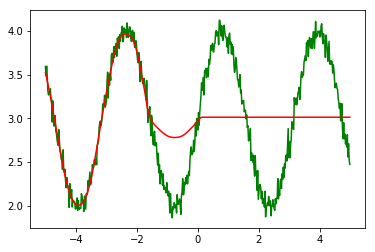

mae = 0.4053677962190918
mse = 0.2867093048667126


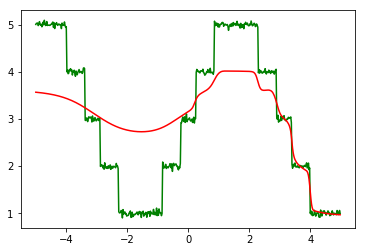

mae = 0.786854951093894
mse = 0.9801266847655944


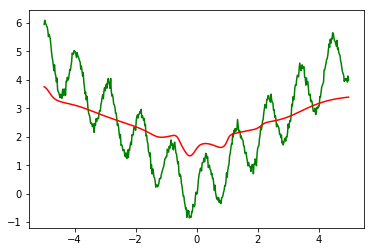

mae = 0.920445699206904
mse = 1.2130936860319421


In [19]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resSigmoid_sin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_sin,y_f1)))
print( "mse = " + str(mse(resSigmoid_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resSigmoid_round, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_round,y_f2)))
print( "mse = " + str(mse(resSigmoid_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resSigmoid_absin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_absin,y_f3)))
print( "mse = " + str(mse(resSigmoid_absin,y_f3)))

### Section 2.4: Tanh

In [21]:
# model with tanh

mlp_tanh = MLP(x_batch,[8,8,8,1], ['tanh','tanh','tanh','identity'])

# output layer
y_pred = mlp_tanh[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelTanh = opt.minimize(avg_llh)

In [22]:
# train model
resTanh_sin = testFunctionActivation(5,x,y_f1,modelTanh)
resTanh_round = testFunctionActivation(5,x,y_f2,modelTanh)
resTanh_absin = testFunctionActivation(5,x,y_f3,modelTanh)

Loss =  8.988384
Loss =  0.012914287
Loss =  0.006810872
Loss =  0.0060514496
Loss =  9.131759
Loss =  0.04475306
Loss =  0.0067851217
Loss =  0.0071111475
Loss =  8.184383
Loss =  0.04955246
Loss =  0.0054934127
Loss =  0.0052447272
Loss =  8.825301
Loss =  0.39262745
Loss =  0.1950512
Loss =  0.22940934
Loss =  8.8126
Loss =  0.006767487
Loss =  0.0076234546
Loss =  0.007195614
Loss =  9.789474
Loss =  0.066458575
Loss =  0.04394068
Loss =  0.036855984
Loss =  9.8741045
Loss =  0.049286097
Loss =  0.030317547
Loss =  0.012161691
Loss =  11.14124
Loss =  0.06512657
Loss =  0.036533397
Loss =  0.015315804
Loss =  10.840641
Loss =  0.07891023
Loss =  0.024066124
Loss =  0.030552402
Loss =  10.874389
Loss =  0.06766756
Loss =  0.06036428
Loss =  0.048028763
Loss =  9.62125
Loss =  2.2559855
Loss =  2.4983382
Loss =  2.5897474
Loss =  9.267171
Loss =  0.46310082
Loss =  0.14794274
Loss =  0.11031553
Loss =  8.302791
Loss =  0.63384515
Loss =  0.18754277
Loss =  0.15478845
Loss =  7.899024

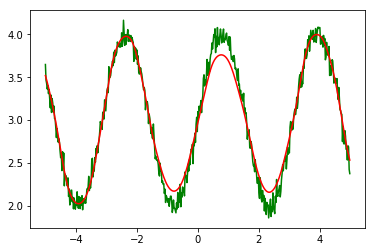

mae = 0.09403564063267321
mse = 0.014310752437950798


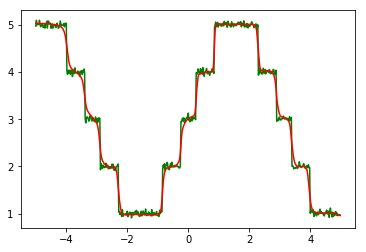

mae = 0.08195714944328057
mse = 0.018574205632949814


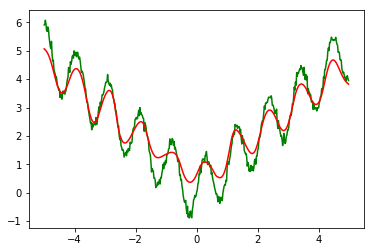

mae = 0.3469843766602701
mse = 0.19230512639149674


In [23]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resTanh_sin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_sin,y_f1)))
print( "mse = " + str(mse(resTanh_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resTanh_round, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_round,y_f2)))
print( "mse = " + str(mse(resTanh_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resTanh_absin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_absin,y_f3)))
print( "mse = " + str(mse(resTanh_absin,y_f3)))

### Section 2.4: Identité

In [24]:
# model without activation

mlp_id = MLP(x_batch,[8,8,8,1], ['identity','identity','identity','identity'])

# output layer
y_pred = mlp_id[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelId = opt.minimize(avg_llh)

In [25]:
# train model
resId_sin = testFunctionActivation(5,x,y_f1,modelId)
resId_round = testFunctionActivation(5,x,y_f2,modelId)
resId_absin = testFunctionActivation(5,x,y_f3,modelId)

Loss =  8.674439
Loss =  0.5546979
Loss =  0.45857796
Loss =  0.4860231
Loss =  8.697675
Loss =  0.42861167
Loss =  0.4659771
Loss =  0.4983523
Loss =  9.1366005
Loss =  0.53935087
Loss =  0.4254836
Loss =  0.41587487
Loss =  9.150111
Loss =  0.43689364
Loss =  0.5094569
Loss =  0.4196538
Loss =  8.595792
Loss =  0.45162034
Loss =  0.44234684
Loss =  0.45564234
Loss =  10.22185
Loss =  2.1025846
Loss =  2.222048
Loss =  2.4124296
Loss =  9.124162
Loss =  2.034002
Loss =  2.2909777
Loss =  1.7887046
Loss =  11.658672
Loss =  2.1861663
Loss =  2.3165739
Loss =  2.303417
Loss =  11.275243
Loss =  2.1500778
Loss =  2.25262
Loss =  2.2406573
Loss =  12.31758
Loss =  2.1350238
Loss =  1.9727739
Loss =  2.1735117
Loss =  7.6050134
Loss =  2.3371437
Loss =  2.7219336
Loss =  2.6459205
Loss =  8.972086
Loss =  2.2891665
Loss =  2.2141585
Loss =  2.9697187
Loss =  8.714302
Loss =  2.4150028
Loss =  2.5899277
Loss =  2.8367567
Loss =  7.56857
Loss =  2.6226685
Loss =  2.228925
Loss =  2.724566
Lo

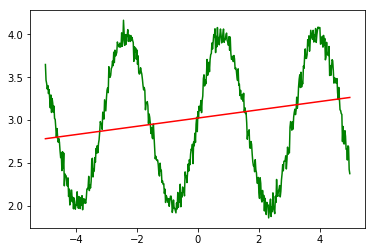

mae = 0.6021625457967068
mse = 0.4631352706272333


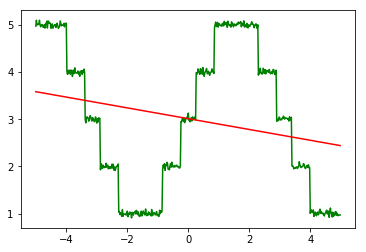

mae = 1.3195517210486363
mse = 2.2104702783278727


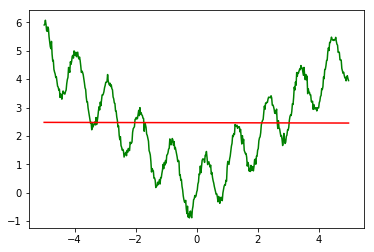

mae = 1.355187729399538
mse = 2.6035380335989156


In [26]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resId_sin, 'red')
plt.show()

print( "mae = " + str(mae(resId_sin,y_f1)))
print( "mse = " + str(mse(resId_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resId_round, 'red')
plt.show()

print( "mae = " + str(mae(resId_round,y_f2)))
print( "mse = " + str(mse(resId_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resId_absin, 'red')
plt.show()

print( "mae = " + str(mae(resId_absin,y_f3)))
print( "mse = " + str(mse(resId_absin,y_f3)))

## Part 3: Généralisation

Dans cette partie, nous allons ajouter des indicateurs concernant la généralisation de nos algorithmes.

### Section 3.1: train/test

In [20]:
def train_test(x,y,ratio):
    union = np.hstack((x,y))
    np.random.shuffle(union)
    split = np.hsplit(union,2)
    ratio_separate = int(ratio * len(x))
    return (split[0][:ratio_separate],split[0][ratio_separate:],split[1][:ratio_separate],split[1][ratio_separate:])
    
    

In [21]:
x_train_f1,x_test_f1,y_train_f1,y_test_f1 = train_test(x,y_f1,0.8)
x_train_f2,x_test_f2,y_train_f2,y_test_f2 = train_test(x,y_f2,0.8)
x_train_f3,x_test_f3,y_train_f3,y_test_f3 = train_test(x,y_f3,0.8)

### Section 3.2: Fit with train/test

In [22]:
def Fit(x_train,x_test,y_train,y_test,model, verbose = 500):
    sess = tf.InteractiveSession()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    visualisation = []
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            feed_dict_train = {x_batch: x_train, y_batch: y_train}
            feed_dict_test = {x_batch: x_test, y_batch: y_test}
            loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
            loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
            print("Epoch: ", epoch)
            print("Loss train = ", loss_train)
            print("Loss test = ", loss_test)
            visualisation.append(np.array([epoch,loss_train,loss_test]))
    return (sess,np.array(visualisation))

In [23]:
mlp1 = MLP(x_batch,[8,8,1], ['relu','relu','identity'])

# output layer
y_pred = mlp1[-1]

# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [24]:
# fit the model
modelFit,visu = Fit(x_train_f1,x_test_f1,y_train_f1,y_test_f1,model)

Epoch:  0
Loss train =  8.6281595
Loss test =  9.53429
Epoch:  500
Loss train =  0.45240974
Loss test =  0.44603503
Epoch:  1000
Loss train =  0.4452761
Loss test =  0.46118987
Epoch:  1500
Loss train =  0.42750564
Loss test =  0.4131726
Epoch:  2000
Loss train =  0.44554672
Loss test =  0.470743
Epoch:  2500
Loss train =  0.4262069
Loss test =  0.40234306
Epoch:  3000
Loss train =  0.42714489
Loss test =  0.3953521
Epoch:  3500
Loss train =  0.4086523
Loss test =  0.42414543
Epoch:  4000
Loss train =  0.40164748
Loss test =  0.38856933
Epoch:  4500
Loss train =  0.4082113
Loss test =  0.44043013
Epoch:  5000
Loss train =  0.38317108
Loss test =  0.40026066
Epoch:  5500
Loss train =  0.38435182
Loss test =  0.40137064
Epoch:  6000
Loss train =  0.37126514
Loss test =  0.3759082
Epoch:  6500
Loss train =  0.3845344
Loss test =  0.37470233
Epoch:  7000
Loss train =  0.37888816
Loss test =  0.3715944
Epoch:  7500
Loss train =  0.3825892
Loss test =  0.38875675
Epoch:  8000
Loss train =  0

In [25]:
def print_visu(visu):
    error = np.hsplit(visu,3)
    plt.plot(error[0],error[1], 'green', label='train')
    plt.plot(error[0],error[2], 'red',label='test')
    plt.legend()
    plt.show()

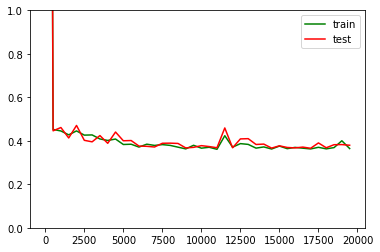

In [26]:
plt.axis(ymax=1,y_min = 0)
print_visu(visu)

La courbe de test est plus basse .....

Il faut tester sur des données plus complexes. Nous allons voir avec les données MNIST

## Part 4: MNIST

### Section 4.1: Récupération des données

In [29]:
mnist = tf.keras.datasets.mnist

In [30]:
# download data
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [31]:
def mnist_label(i):
    label = np.zeros(10)
    label[i] = 1
    return label

In [32]:
y_train_mnist = np.array([mnist_label(y_train[i]) for i in range(len(y_train))])
y_test_mnist = np.array([mnist_label(y_test[i]) for i in range(len(y_test))])

In [33]:
#reformat data
x_train = x_train.reshape(60000,784).astype(float)
y_train = y_train_mnist.reshape(60000,10).astype(float)
x_test = x_test.reshape(10000,784).astype(float)
y_test = y_test_mnist.reshape(10000,10).astype(float)

### Section 4.2: Création d'un MLP pour la classif

In [41]:
epochs = 15000
batch_size = 500

x_batch = tf.placeholder(shape=[None, 784], dtype=tf.float32, name='x_batch')
y_batch = tf.placeholder(shape=[None, 10], dtype=tf.float32, name='y_batch')

In [42]:
mlp_mnist = MLP(x_batch,[512,512,10], ['sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
#opt = tf.train.GradientDescentOptimizer(0.5)

model_mnist = opt.minimize(avg_llh)

In [43]:
# fit the model
modelFit_mnist,visu = Fit(x_train,x_test,y_train,y_test,model_mnist)

Epoch:  0
Loss train =  2.3067572
Loss test =  2.293842
Epoch:  500
Loss train =  0.17242275
Loss test =  0.18229641
Epoch:  1000
Loss train =  0.14220655
Loss test =  0.15880454
Epoch:  1500
Loss train =  0.118978
Loss test =  0.13822286
Epoch:  2000
Loss train =  0.10794287
Loss test =  0.13053198
Epoch:  2500
Loss train =  0.092969306
Loss test =  0.118204154
Epoch:  3000
Loss train =  0.09347392
Loss test =  0.12425674
Epoch:  3500
Loss train =  0.081589416
Loss test =  0.113862015
Epoch:  4000
Loss train =  0.084757924
Loss test =  0.11726267
Epoch:  4500
Loss train =  0.069282554
Loss test =  0.104988076
Epoch:  5000
Loss train =  0.06823106
Loss test =  0.10476644
Epoch:  5500
Loss train =  0.057958644
Loss test =  0.10039535
Epoch:  6000
Loss train =  0.064417854
Loss test =  0.100218944
Epoch:  6500
Loss train =  0.05622105
Loss test =  0.08795397
Epoch:  7000
Loss train =  0.049005434
Loss test =  0.08670979
Epoch:  7500
Loss train =  0.050306316
Loss test =  0.09481154
Epoch

In [44]:
writer = tf.summary.FileWriter("/tmp/graph/2")
writer.add_graph(modelFit_mnist.graph)

In [45]:
result_mnist = Predict(x_test,modelFit_mnist)

In [46]:
correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

0.9755


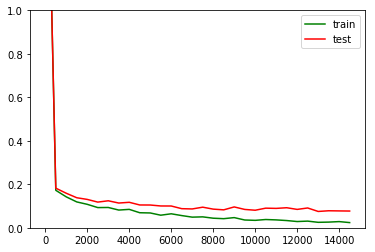

In [48]:
plt.axis(ymax=1,y_min = 0)
print_visu(visu)

### Section 5: Early Stopping

In [49]:
def ES(x_train,x_test,y_train,y_test,model,n = 500, p = 15, verbose = 500):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    saver = tf.train.Saver()
    visualisation = []
    j = 0
    step = 0
    best_loss = np.inf
    while j < p:
        # train n steps
        for i in range(n):
            indices = np.random.choice(x_train.shape[0], size=batch_size)
            x_b = x_train[indices]
            y_b = y_train[indices]
            feed_dict = {x_batch: x_b, y_batch: y_b}
            sess.run(model, feed_dict=feed_dict)
            step = step+1
        # compute en print actual score
        feed_dict_train = {x_batch: x_train, y_batch: y_train}
        feed_dict_test = {x_batch: x_test, y_batch: y_test}
        loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
        loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
        print("Loss train = ", loss_train)
        print("Loss test = ", loss_test)
        visualisation.append(np.array([step,loss_train,loss_test]))
        #compare loss
        if loss_test < best_loss:
            save_path = saver.save(sess, "/tmp/best_model.ckpt")
            j = 0
            best_loss = loss_test
        else:
            j = j+1
    best_model = saver.restore(sess, "/tmp/best_model.ckpt")
    return (sess,np.array(visualisation))

### Section 5.3: Test sur Sigmoid

In [50]:
mlp_mnist = MLP(x_batch,[128,128,10], ['sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [51]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  0.27046746
Loss test =  0.27007467
Loss train =  0.20548883
Loss test =  0.21001941
Loss train =  0.1829968
Loss test =  0.19646187
Loss train =  0.15704927
Loss test =  0.1681057
Loss train =  0.15336667
Loss test =  0.16576327
Loss train =  0.13603154
Loss test =  0.15772322
Loss train =  0.12722167
Loss test =  0.14888173
Loss train =  0.12161359
Loss test =  0.14129183
Loss train =  0.11751352
Loss test =  0.14144534
Loss train =  0.10986224
Loss test =  0.13606326
Loss train =  0.10891452
Loss test =  0.13643831
Loss train =  0.102526605
Loss test =  0.13515332
Loss train =  0.095677145
Loss test =  0.123215966
Loss train =  0.09207245
Loss test =  0.12831181
Loss train =  0.09114799
Loss test =  0.12946571
Loss train =  0.090859234
Loss test =  0.12323042
Loss train =  0.08654731
Loss test =  0.11932677
Loss train =  0.084728636
Loss test =  0.122034445
Loss train =  0.082485534
Loss test =  0.114993066
Loss train =  0.07413967
Loss test =  0.11397912
Loss train =  

In [52]:
result_mnist = Predict(x_test,ES_fit_mnist)

In [53]:
correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

0.9747


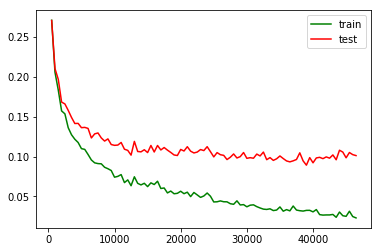

In [54]:
# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

### Section 5.2: Test sur Relu

In [55]:
# RELU

mlp_mnist = MLP(x_batch,[128,128,10], ['relu','relu','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [56]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  0.4621584
Loss test =  0.9374379
Loss train =  0.14951563
Loss test =  0.71041083
Loss train =  0.050816398
Loss test =  0.63920814
Loss train =  0.04468311
Loss test =  0.64734733
Loss train =  0.03392903
Loss test =  0.5900644
Loss train =  0.039619856
Loss test =  0.6138261
Loss train =  0.03391718
Loss test =  0.5785265
Loss train =  0.059584897
Loss test =  0.66838694
Loss train =  0.041187033
Loss test =  0.6185672
Loss train =  0.049230598
Loss test =  0.6699363
Loss train =  0.0358269
Loss test =  0.58909637
Loss train =  0.038888652
Loss test =  0.673432
Loss train =  0.075295225
Loss test =  0.67735064
Loss train =  0.028848521
Loss test =  0.5934508
Loss train =  0.059406124
Loss test =  0.6384405
Loss train =  0.028341921
Loss test =  0.7315985
Loss train =  0.04751943
Loss test =  0.6698154
Loss train =  0.029746797
Loss test =  0.74496084
Loss train =  0.020405669
Loss test =  0.6825045
Loss train =  0.06433632
Loss test =  0.87907803
Loss train =  0.0265307

0.9607


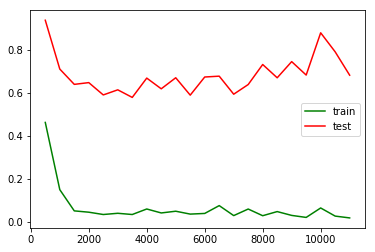

In [57]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

Dropout pour réduire l'overfit

In [58]:
# test avec dropout

# RELU

mlp_mnist = MLP(x_batch,[128,128,10], ['relu','relu','identity'], dropout = 0.8)

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [59]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  0.79068065
Loss test =  0.87111896
Loss train =  0.42311153
Loss test =  0.50016683
Loss train =  0.2965537
Loss test =  0.40808272
Loss train =  0.23804407
Loss test =  0.33640608
Loss train =  0.19310166
Loss test =  0.30109644
Loss train =  0.16549906
Loss test =  0.27856857
Loss train =  0.1459478
Loss test =  0.25546676
Loss train =  0.12688579
Loss test =  0.23745464
Loss train =  0.11737877
Loss test =  0.2403602
Loss train =  0.10449146
Loss test =  0.2235499
Loss train =  0.09982605
Loss test =  0.2208228
Loss train =  0.09861616
Loss test =  0.22125772
Loss train =  0.09020561
Loss test =  0.22196272
Loss train =  0.075038455
Loss test =  0.19987701
Loss train =  0.07350457
Loss test =  0.1962335
Loss train =  0.07853144
Loss test =  0.2244304
Loss train =  0.06282394
Loss test =  0.22055674
Loss train =  0.06482734
Loss test =  0.21156316
Loss train =  0.062807
Loss test =  0.21761264
Loss train =  0.0591908
Loss test =  0.19782935
Loss train =  0.057031
Loss t

0.9637


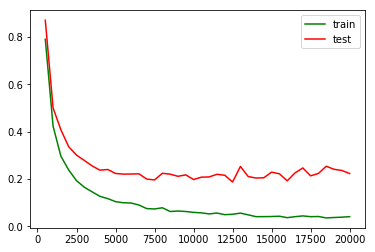

In [60]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

### Section 5.3: Test sur Tanh

In [62]:
# tanh

mlp_mnist = MLP(x_batch,[128,128,10], ['tanh','tanh','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [63]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  0.27088618
Loss test =  0.27417687
Loss train =  0.20789923
Loss test =  0.21611255
Loss train =  0.18091609
Loss test =  0.19026093
Loss train =  0.17221019
Loss test =  0.18154941
Loss train =  0.15372756
Loss test =  0.15894797
Loss train =  0.14649655
Loss test =  0.16512838
Loss train =  0.1287701
Loss test =  0.1555779
Loss train =  0.11996548
Loss test =  0.14661829
Loss train =  0.11319923
Loss test =  0.1468236
Loss train =  0.113583125
Loss test =  0.13928261
Loss train =  0.11458975
Loss test =  0.14003965
Loss train =  0.10219409
Loss test =  0.12812886
Loss train =  0.103183955
Loss test =  0.124831796
Loss train =  0.109480225
Loss test =  0.14769073
Loss train =  0.09817451
Loss test =  0.13687395
Loss train =  0.101376094
Loss test =  0.14133003
Loss train =  0.09399743
Loss test =  0.12942548
Loss train =  0.100665316
Loss test =  0.13610178
Loss train =  0.09005959
Loss test =  0.1328706
Loss train =  0.08944087
Loss test =  0.131839
Loss train =  0.0818

0.9662


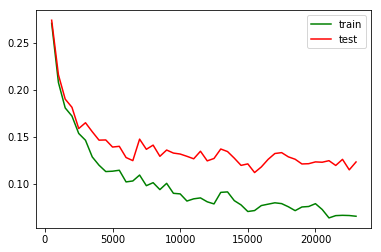

In [64]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

### Section 5.3: Test sur identity

In [65]:

mlp_mnist = MLP(x_batch,[128,128,10], ['identity','identity','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [66]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  2.0002825
Loss test =  2.1756978
Loss train =  1.361019
Loss test =  1.5419673
Loss train =  1.1561036
Loss test =  1.3011147
Loss train =  0.94093764
Loss test =  1.0778574
Loss train =  0.7156421
Loss test =  0.82132286
Loss train =  0.6478055
Loss test =  0.7362764
Loss train =  0.60867333
Loss test =  0.70631516
Loss train =  0.5183444
Loss test =  0.6313661
Loss train =  0.4711121
Loss test =  0.5465663
Loss train =  0.4001951
Loss test =  0.47602475
Loss train =  0.4287096
Loss test =  0.5441589
Loss train =  0.39227733
Loss test =  0.48731142
Loss train =  0.36715108
Loss test =  0.4709712
Loss train =  0.3407186
Loss test =  0.4178417
Loss train =  0.31014004
Loss test =  0.3854445
Loss train =  0.30475354
Loss test =  0.3901168
Loss train =  0.31823528
Loss test =  0.3918732
Loss train =  0.3256667
Loss test =  0.40663648
Loss train =  0.2927701
Loss test =  0.36642852
Loss train =  0.28255925
Loss test =  0.35908842
Loss train =  0.28464544
Loss test =  0.350584

0.92


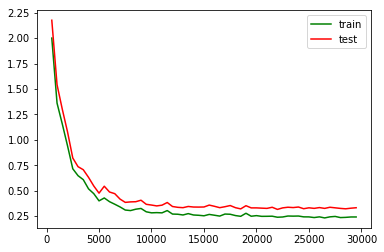

In [67]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

### Section 5.5: Fit sans capacité

In [68]:
# SIGMOID

mlp_mnist = MLP(x_batch,[4,4,10], ['sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [69]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  2.039614
Loss test =  2.0438604
Loss train =  1.8701398
Loss test =  1.8745965
Loss train =  1.774294
Loss test =  1.7743309
Loss train =  1.6957821
Loss test =  1.699259
Loss train =  1.6096579
Loss test =  1.6191514
Loss train =  1.454313
Loss test =  1.4611741
Loss train =  1.2969266
Loss test =  1.3038164
Loss train =  1.192397
Loss test =  1.2031124
Loss train =  1.1089902
Loss test =  1.1234307
Loss train =  1.0520135
Loss test =  1.0530971
Loss train =  0.99495256
Loss test =  0.996698
Loss train =  0.9832073
Loss test =  0.9819955
Loss train =  0.9047109
Loss test =  0.913525
Loss train =  0.87920916
Loss test =  0.88737
Loss train =  0.8612718
Loss test =  0.8683279
Loss train =  0.8468711
Loss test =  0.84592015
Loss train =  0.82238156
Loss test =  0.8285074
Loss train =  0.8280536
Loss test =  0.83431876
Loss train =  0.81233245
Loss test =  0.8212422
Loss train =  0.811995
Loss test =  0.8299716
Loss train =  0.7850857
Loss test =  0.7929149
Loss train =  0.7

0.7706


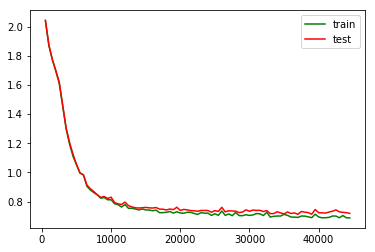

In [70]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

In [71]:
# relu

mlp_mnist = MLP(x_batch,[4,4,10], ['relu','relu','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [72]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  1.2810779
Loss test =  1.2415842
Loss train =  0.7805755
Loss test =  0.78231436
Loss train =  0.6523
Loss test =  0.6684018
Loss train =  0.54486626
Loss test =  0.56341046
Loss train =  0.5092855
Loss test =  0.5271237
Loss train =  0.48665723
Loss test =  0.50370544
Loss train =  0.4727247
Loss test =  0.4940663
Loss train =  0.46409342
Loss test =  0.48467866
Loss train =  0.46281278
Loss test =  0.48654154
Loss train =  0.4510393
Loss test =  0.47630033
Loss train =  0.44477507
Loss test =  0.47104317
Loss train =  0.4405505
Loss test =  0.46903569
Loss train =  0.43583453
Loss test =  0.46173263
Loss train =  0.43425465
Loss test =  0.46521923
Loss train =  0.43572176
Loss test =  0.4668953
Loss train =  0.43289843
Loss test =  0.4622568
Loss train =  0.43149772
Loss test =  0.46286035
Loss train =  0.43654317
Loss test =  0.47015443
Loss train =  0.4281535
Loss test =  0.4604069
Loss train =  0.43503645
Loss test =  0.4746875
Loss train =  0.43264583
Loss test =  0

0.8739


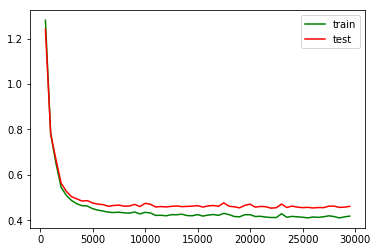

In [73]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

In [74]:
# tanh

mlp_mnist = MLP(x_batch,[4,4,10], ['tanh','tanh','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [75]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  1.562406
Loss test =  1.5378677
Loss train =  1.239091
Loss test =  1.2172265
Loss train =  1.125697
Loss test =  1.0986284
Loss train =  0.9935593
Loss test =  0.97212714
Loss train =  0.9483573
Loss test =  0.9343666
Loss train =  0.9087599
Loss test =  0.8938999
Loss train =  0.87278706
Loss test =  0.8631829
Loss train =  0.8700913
Loss test =  0.8584793
Loss train =  0.8450224
Loss test =  0.8246775
Loss train =  0.84989387
Loss test =  0.8355756
Loss train =  0.8444738
Loss test =  0.820147
Loss train =  0.8022581
Loss test =  0.7984765
Loss train =  0.81302047
Loss test =  0.8094201
Loss train =  0.8243468
Loss test =  0.8149321
Loss train =  0.8073157
Loss test =  0.81242746
Loss train =  0.7833505
Loss test =  0.7810387
Loss train =  0.7827506
Loss test =  0.78984433
Loss train =  0.798176
Loss test =  0.796477
Loss train =  0.7781143
Loss test =  0.77648026
Loss train =  0.7914306
Loss test =  0.78891027
Loss train =  0.7727543
Loss test =  0.7846792
Loss train 

0.7796


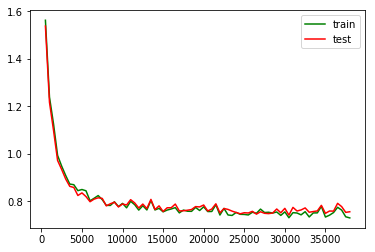

In [76]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

In [77]:
# identity

mlp_mnist = MLP(x_batch,[4,4,10], ['identity','identity','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [78]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  0.67842853
Loss test =  0.67580354
Loss train =  0.4990713
Loss test =  0.49828574
Loss train =  0.46215656
Loss test =  0.46642655
Loss train =  0.4495052
Loss test =  0.4597327
Loss train =  0.4409279
Loss test =  0.45614982
Loss train =  0.4388158
Loss test =  0.45624974
Loss train =  0.43434864
Loss test =  0.45070285
Loss train =  0.42876515
Loss test =  0.4507796
Loss train =  0.4282325
Loss test =  0.45243296
Loss train =  0.42856848
Loss test =  0.4585507
Loss train =  0.4228418
Loss test =  0.44879013
Loss train =  0.4200606
Loss test =  0.45352167
Loss train =  0.42186737
Loss test =  0.45778048
Loss train =  0.42088735
Loss test =  0.45855206
Loss train =  0.42212978
Loss test =  0.45334694
Loss train =  0.42090353
Loss test =  0.45863047
Loss train =  0.42215624
Loss test =  0.4592875
Loss train =  0.4149309
Loss test =  0.4568099
Loss train =  0.41724303
Loss test =  0.45810625
Loss train =  0.4248425
Loss test =  0.4729359
Loss train =  0.41816375
Loss test 

0.8747


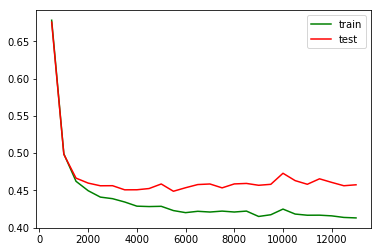

In [79]:
result_mnist = Predict(x_test,ES_fit_mnist)

correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

## Part 6: Fit en live

In [80]:
%matplotlib notebook

def update_line(ax,fig,x_train,y_train,x_test, y_pred):
    plt.pause(0.05)
    ax.clear()
    m = max(y_train)
    mm = min(y_train)
    
    plt.axis(ymax=m*1.1,y_min = mm - 1)
    ax.plot(x_train, y_train, color = 'blue')
    ax.plot(x_test, y_pred, color = 'red')
    fig.canvas.draw()


def ES_dynamic_print(x_train,x_test,y_train,y_test,model,n = 250, p = 20, verbose = 500):
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    plt.plot(x_train, y_train)
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    saver = tf.train.Saver()
    visualisation = []
    j = 0
    step = 0
    best_loss = np.inf
    while j < p:
        # train n steps
        for i in range(n):
            indices = np.random.choice(x_train.shape[0], size=batch_size)
            x_b = x_train[indices]
            y_b = y_train[indices]
            feed_dict = {x_batch: x_b, y_batch: y_b}
            sess.run(model, feed_dict=feed_dict)
            step = step+1
        # compute en print actual score
        feed_dict_train = {x_batch: x_train, y_batch: y_train}
        feed_dict_test = {x_batch: x_test, y_batch: y_test}
        loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
        loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
        pred = sess.run(y_pred, feed_dict=feed_dict_test)
        # affichage plot
        update_line(ax,fig,x_train,y_train,x_test,pred)
        visualisation.append(np.array([step,loss_train,loss_test]))
        #compare loss
        if loss_test < best_loss:
            save_path = saver.save(sess, "/tmp/best_model.ckpt")
            j = 0
            best_loss = loss_test
        else:
            j = j+1
    best_model = saver.restore(sess, "/tmp/best_model.ckpt")
    return (sess,np.array(visualisation))

In [93]:
x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='x_batch')
y_batch = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_batch')

mlp1 = MLP(x_batch,[4,4,1], ['relu','relu','identity'])

# output layer
y_pred = mlp1[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model = opt.minimize(avg_llh)

<IPython.core.display.Javascript object>


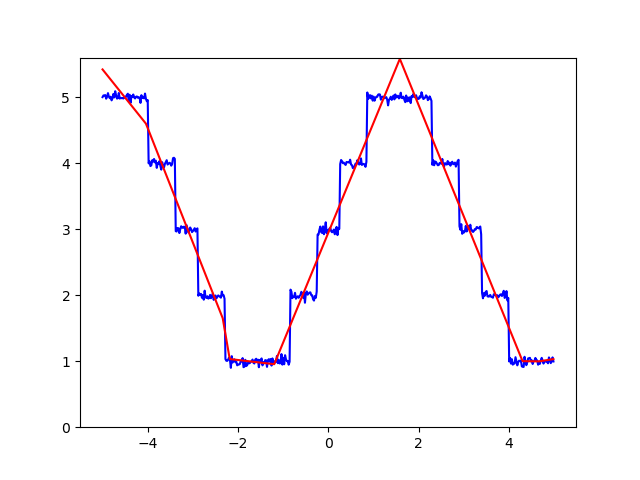

KeyboardInterrupt: 

In [94]:
ESfit = ES_dynamic_print(x,x,y_f2,y_f2,model)

In [63]:
def image_array(images):
    "Matplotlib function to display a group of images inline as a block"
    num_cols = 5
    num_rows = len(images) / num_cols + 1
    plt.figure(figsize=[num_cols * 1.5, num_rows * 1.5])
    plt.gray()
    for i, data in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')
        plt.imshow(images[i])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<IPython.core.display.Javascript object>


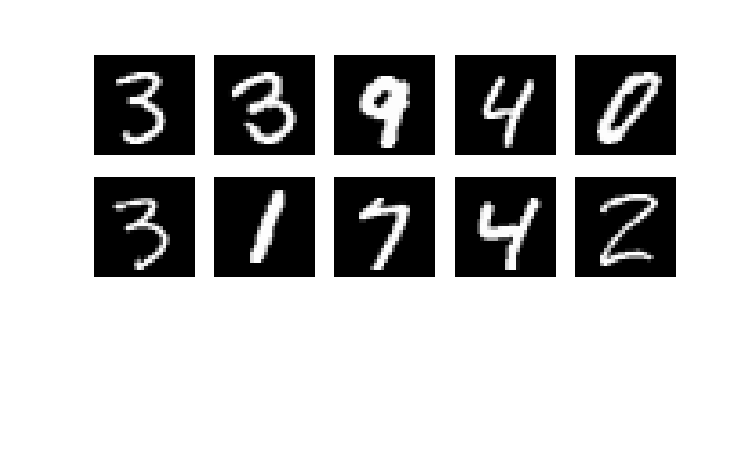

In [64]:
# Display some samples from the training set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

image_array(mnist.train.next_batch(10)[0].reshape(10, 28, 28))

In [65]:
%%time

sess = tf.InteractiveSession()

# What kind of training optimizer we use
optimizer = tf.train.AdamOptimizer(0.001)

# Placeholders for the input data; images and labels
x = tf.placeholder(tf.float32, shape=[None, 28*28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

y_conv = MLP(x,[512,512,10],["sigmoid","sigmoid","identity"])[-1]

# Cost function for the network
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

# Optimization setup for training
train_step = optimizer.minimize(cross_entropy)



# Accuracy measure: do the y_conv predictions match the y_ inputs?
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



sess.run(tf.global_variables_initializer())

for i in range(2400):
    # Grab a bit of training data. Note this batching function is quite slow.
    batch = mnist.train.next_batch(1000)
    
    # Report training progress every 100 steps
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print('step %d, training accuracy %g, test accuracy %g' % (i, train_accuracy, test_accuracy))
        
    # Run the training step
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

# Report on final accuracy
test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

sess.close()





/home/adeleruyelle/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.09, test accuracy 0.0958
step 100, training accuracy 0.9, test accuracy 0.9075
step 200, training accuracy 0.919, test accuracy 0.9212
step 300, training accuracy 0.926, test accuracy 0.9342
step 400, training accuracy 0.942, test accuracy 0.9437
step 500, training accuracy 0.954, test accuracy 0.9496
step 600, training accuracy 0.963, test accuracy 0.9554
step 700, training accuracy 0.964, test accuracy 0.9586
step 800, training accuracy 0.969, test accuracy 0.9616
step 900, training accuracy 0.966, test accuracy 0.9646
step 1000, training accuracy 0.969, test accuracy 0.968
step 1100, training accuracy 0.975, test accuracy 0.9691
step 1200, training accuracy 0.99, test accuracy 0.9706
step 1300, training accuracy 0.975, test accuracy 0.9717
step 1400, training accuracy 0.985, test accuracy 0.9728
step 1500, training accuracy 0.99, test accuracy 0.9739
step 1600, training accuracy 0.992, test accuracy 0.9738
step 1700, training accuracy 0.991, test accuracy